In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

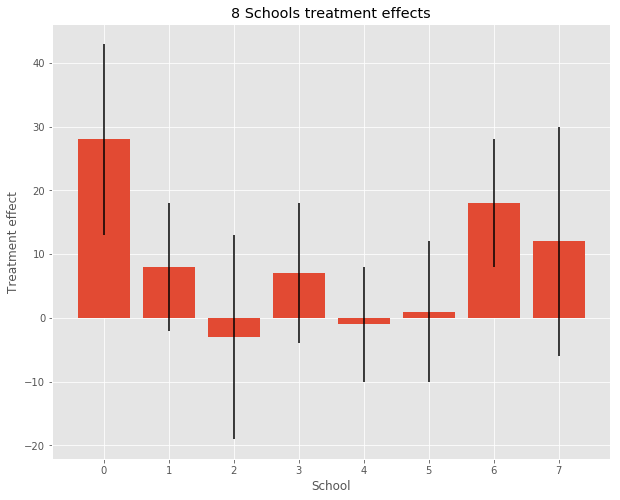

In [2]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [3]:
def schools_model(num_schools, treatment_stddevs):
  avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
  avg_stddev = ed.Normal(
      loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
  school_effects_standard = ed.Normal(
      loc=tf.zeros(num_schools),
      scale=tf.ones(num_schools),
      name="school_effects_standard")  # `theta_prime` above
  school_effects = avg_effect + tf.exp(
      avg_stddev) * school_effects_standard  # `theta` above
  treatment_effects = ed.Normal(
      loc=school_effects, scale=treatment_stddevs,
      name="treatment_effects")  # `y` above
  return treatment_effects

log_joint = ed.make_log_joint_fn(schools_model)


def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return log_joint(
      num_schools=num_schools,
      treatment_stddevs=treatment_stddevs,
      avg_effect=avg_effect,
      avg_stddev=avg_stddev,
      school_effects_standard=school_effects_standard,
      treatment_effects=treatment_effects)

In [4]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.4,
        num_leapfrog_steps=3))

avg_effect, avg_stddev, school_effects_standard = states

with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.6218


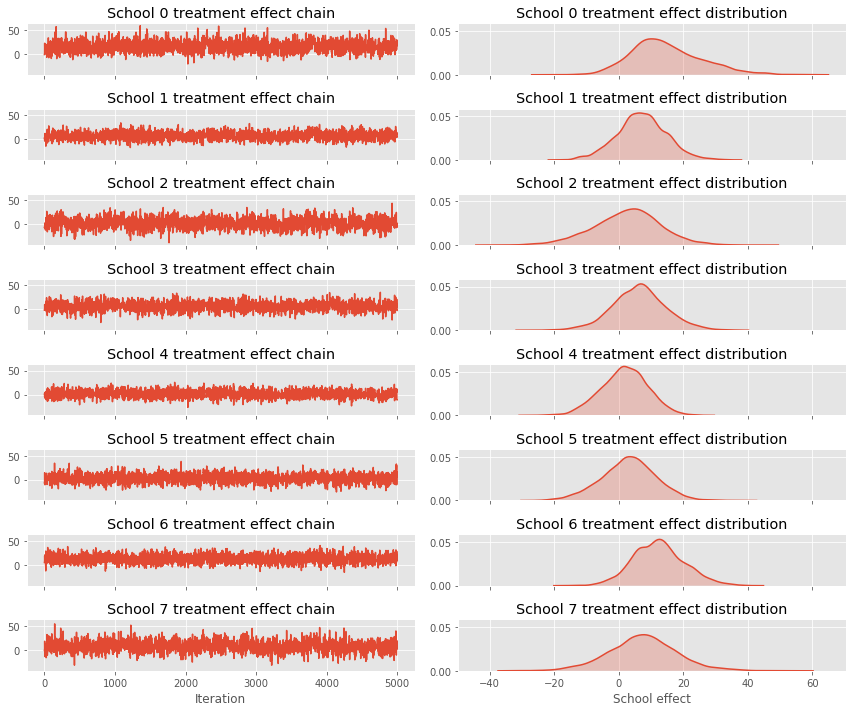

In [5]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [6]:
print("E[avg_effect] = {}".format(avg_effect_.mean()))
print("E[avg_stddev] = {}".format(avg_stddev_.mean()))
print("E[school_effects_standard] =")
print(school_effects_standard_[:, ].mean(0))
print("E[school_effects] =")
print(school_effects_samples[:, ].mean(0))

E[avg_effect] = 5.488248348236084
E[avg_stddev] = 2.4572410583496094
E[school_effects_standard] =
[ 0.6627555   0.12223439 -0.21520193  0.07418291 -0.3053275  -0.2027948
  0.53615564  0.14583041]
E[school_effects] =
[14.750712   7.133304   2.6080391  6.381735   1.8202318  3.1216195
 12.422642   7.4770103]


In [7]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

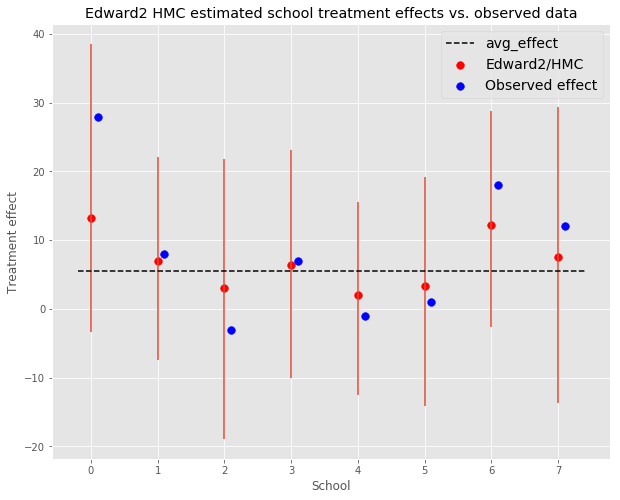

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

avg_effect = avg_effect_.mean()

plt.plot([-0.2, 7.4], [avg_effect, avg_effect], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'Edward2/HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('Edward2 HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()